### Генерация поэзии с помощью нейронных сетей: шаг 1
##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

Ваша основная задача: научиться генерироват стихи с помощью простой рекуррентной нейронной сети (Vanilla RNN). В качестве корпуса текстов для обучения будет выступать роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина.

In [1]:
# do not change the code in the block below
# __________start of block__________
import string
import os
from random import sample

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output

import matplotlib.pyplot as plt
# __________end of block__________

In [2]:
# do not change the code in the block below
# __________start of block__________
device = torch.device('cpu')
print('{} device is available'.format(device))
# __________end of block__________

cpu device is available


#### 1. Загрузка данных.

In [3]:
# do not change the code in the block below
# __________start of block__________
# !wget https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt
    
with open('onegin.txt', 'r', encoding='utf-8') as iofile:
    text = iofile.readlines()
    
text = "".join([x.replace('\t\t', '').lower() for x in text])
# __________end of block__________

#### 2. Построение словаря и предобработка текста
В данном задании требуется построить языковую модель на уровне символов. Приведем весь текст к нижнему регистру и построим словарь из всех символов в доступном корпусе текстов. Также добавим токен `<sos>`.

In [4]:
# do not change the code in the block below
# __________start of block__________
tokens = sorted(set(text.lower())) + ['<sos>']
num_tokens = len(tokens)

assert num_tokens == 84, "Check the tokenization process"

token_to_idx = {x: idx for idx, x in enumerate(tokens)}
idx_to_token = {idx: x for idx, x in enumerate(tokens)}

assert len(tokens) == len(token_to_idx), "Mapping should be unique"

print("Seems fine!")


text_encoded = [token_to_idx[x] for x in text]
# __________end of block__________

Seems fine!


__Ваша задача__: обучить классическую рекуррентную нейронную сеть (Vanilla RNN) предсказывать следующий символ на полученном корпусе текстов и сгенерировать последовательность длины 100 для фиксированной начальной фразы.

Вы можете воспользоваться кодом с занятие №6 или же обратиться к следующим ссылкам:
* Замечательная статья за авторством Andrej Karpathy об использовании RNN: [link](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* Пример char-rnn от Andrej Karpathy: [github repo](https://github.com/karpathy/char-rnn)
* Замечательный пример генерации поэзии Шекспира: [github repo](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb)

Данное задание является достаточно творческим. Не страшно, если поначалу оно вызывает затруднения. Последняя ссылка в списке выше может быть особенно полезна в данном случае.

Далее для вашего удобства реализована функция, которая генерирует случайный батч размера `batch_size` из строк длиной `seq_length`. Вы можете использовать его при обучении модели.

In [5]:
# do not change the code in the block below
# __________start of block__________
batch_size = 256
seq_length = 100
start_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx['<sos>']

def generate_chunk():
    global text_encoded, start_column, batch_size, seq_length

    start_index = np.random.randint(0, len(text_encoded) - batch_size*seq_length - 1)
    data = np.array(text_encoded[start_index:start_index + batch_size*seq_length]).reshape((batch_size, -1))
    yield np.hstack((start_column, data))
# __________end of block__________    

Пример батча:

In [6]:
next(generate_chunk())

array([[83, 70, 50, ..., 55, 64, 68],
       [83, 53, 56, ..., 49, 61, 64],
       [83, 51, 46, ..., 63, 72, 56],
       ...,
       [83, 55, 53, ..., 53,  1, 56],
       [83, 45, 62, ...,  1, 53, 66],
       [83,  1, 49, ..., 45, 50, 63]])

Далее вам предстоит написать код для обучения модели и генерации текста.

In [7]:
# Определение модели Vanilla RNN
class VanillaRNN(nn.Module):
    def __init__(self, input_size, embed_size, hidden_size, output_size, num_layers=1):
        super(VanillaRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Встраивание символов
        self.embedding = nn.Embedding(input_size, embed_size)
        
        # Рекуррентный слой
        self.rnn = nn.RNN(embed_size, hidden_size, num_layers, nonlinearity='tanh', batch_first=True)
        
        # Полносвязный слой
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, hidden):
        # x: (batch_size, seq_length)
        embedded = self.embedding(x)  # (batch_size, seq_length, embed_size)
        out, hidden = self.rnn(embedded, hidden)  # out: (batch_size, seq_length, hidden_size)
        out = out.reshape(out.size(0)*out.size(1), self.hidden_size)  # (batch_size*seq_length, hidden_size)
        out = self.fc(out)  # (batch_size*seq_length, output_size)
        return out, hidden
    
    def init_hidden(self, batch_size):
        # Инициализация скрытого состояния
        return torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)


In [8]:
# Гиперпараметры
embed_size = 128
hidden_size = 256
num_layers = 2
num_epochs = 2000
learning_rate = 0.003

# Инициализация модели
model = VanillaRNN(input_size=num_tokens, 
                   embed_size=embed_size, 
                   hidden_size=hidden_size, 
                   output_size=num_tokens, 
                   num_layers=num_layers).to(device)

# Функция потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [9]:
# Функция для обучения модели
def train(model, epochs, print_every=100):
    model.train()
    for epoch in range(1, epochs+1):
        hidden = model.init_hidden(batch_size)
        for batch_idx, batch in enumerate(generate_chunk(), 1):
            # Преобразование данных в тензоры
            inputs = torch.tensor(batch[:, :-1], dtype=torch.long).to(device)  # (batch_size, seq_length)
            targets = torch.tensor(batch[:, 1:], dtype=torch.long).to(device)  # (batch_size, seq_length)
            
            # Очистка градиентов
            optimizer.zero_grad()
            
            # Прямой проход
            outputs, hidden = model(inputs, hidden.detach())
            loss = criterion(outputs, targets.reshape(-1))
            
            # Обратный проход и оптимизация
            loss.backward()
            optimizer.step()
            
            if batch_idx % print_every == 0:
                print(f'Epoch [{epoch}/{epochs}], Batch [{batch_idx}], Loss: {loss.item():.4f}')
        if int(epoch % 100) == 0:
            print(f'--- Epoch {epoch} завершена ---', loss)

# Запуск обучения
train(model, epochs=num_epochs)


--- Epoch 1 завершена --- tensor(4.4388, grad_fn=<NllLossBackward0>)
--- Epoch 2 завершена --- tensor(3.9918, grad_fn=<NllLossBackward0>)
--- Epoch 3 завершена --- tensor(3.4054, grad_fn=<NllLossBackward0>)
--- Epoch 4 завершена --- tensor(3.2558, grad_fn=<NllLossBackward0>)
--- Epoch 5 завершена --- tensor(3.1763, grad_fn=<NllLossBackward0>)
--- Epoch 6 завершена --- tensor(3.1214, grad_fn=<NllLossBackward0>)
--- Epoch 7 завершена --- tensor(3.0181, grad_fn=<NllLossBackward0>)
--- Epoch 8 завершена --- tensor(2.9383, grad_fn=<NllLossBackward0>)
--- Epoch 9 завершена --- tensor(2.8963, grad_fn=<NllLossBackward0>)
--- Epoch 10 завершена --- tensor(2.8723, grad_fn=<NllLossBackward0>)
--- Epoch 11 завершена --- tensor(2.8543, grad_fn=<NllLossBackward0>)
--- Epoch 12 завершена --- tensor(2.8180, grad_fn=<NllLossBackward0>)
--- Epoch 13 завершена --- tensor(2.7783, grad_fn=<NllLossBackward0>)
--- Epoch 14 завершена --- tensor(2.7744, grad_fn=<NllLossBackward0>)
--- Epoch 15 завершена --- te

In [14]:
# Функция для генерации текста
def generate_text(model, start_str, length=100):
    model.eval()
    generated = start_str
    hidden = model.init_hidden(1)  # batch_size=1
    
    # Преобразование начальной строки в индексы
    input_seq = [token_to_idx.get(char, token_to_idx['<sos>']) for char in start_str]
    input_tensor = torch.tensor([input_seq], dtype=torch.long).to(device)  # shape: (1, len(start_str))
    
    with torch.no_grad():
        # Пропуск начальной строки через модель
        for i in range(len(start_str)-1):
            current_input = input_tensor[:, i].unsqueeze(1)  # shape: (1, 1)
            output, hidden = model(current_input, hidden)
        
        # Получение последнего символа из начальной строки
        last_char = input_tensor[:, -1].unsqueeze(1)  # shape: (1, 1)
        
        for _ in range(length):
            # Вызов модели без лишнего измерения
            output, hidden = model(last_char, hidden)  # last_char: (1, 1)
            
            # Преобразование выходов в вероятности
            probs = F.softmax(output, dim=1).cpu().numpy().squeeze()
            
            # Выбор следующего символа на основе распределения вероятностей
            next_char_idx = np.random.choice(len(probs), p=probs)
            next_char = idx_to_token[next_char_idx]
            generated += next_char
            
            # Подготовка следующего входа
            last_char = torch.tensor([[next_char_idx]], dtype=torch.long).to(device)  # shape: (1, 1)
    
    return generated


# Пример генерации текста
start_phrase = ' мой дядя самых честных правил'
generated_text = generate_text(model, start_phrase, length=500)
print("Сгенерированный текст:")
print(generated_text)


Сгенерированный текст:
 мой дядя самых честных правилась;
пойметерь от удна;
она всех барно готовы,
а что после должно думать
и прочел и в санях;
но мужить?». —
«мой они в мыслев,
и представит не сный почивой,
то вопросила то ропщит готов бандвезь шарушкой и песнить мил он.
нет, не седув закон?
со воспоминать из татим,
не достойна,
с ольги упылкей;
татьяна которанье,
татьяну прелестью рощами, лука,
под ним покелье, задумчивый, унылый
пуст под стихает —
из-блистательная дама
я было ей так ли под хладноюбренье
ее гремучию спит
и что евгений
кретили 


В качестве иллюстрации ниже доступен график значений функции потерь, построенный в ходе обучения авторской сети (сам код для ее обучения вам и предстоит написать).

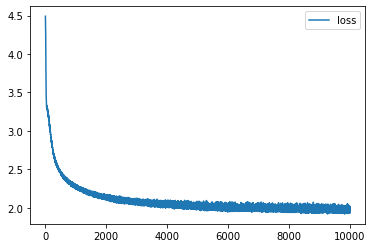

Шаблон функции `generate_sample` также доступен ниже. Вы можете как дозаполнить его, так и написать свою собственную функцию с нуля. Не забывайте, что все примеры в обучающей выборке начинались с токена `<sos>`.

In [27]:
def generate_sample(char_rnn, seed_phrase=None, max_length=200, temperature=1.0, device=device):
    '''
    Функция генерирует текст, начиная с заданной начальной фразы.
    
    :param char_rnn: обученная модель RNN
    :param seed_phrase: начальная фраза для генерации текста
    :param max_length: максимальная длина генерируемого текста, включая начальную фразу
    :param temperature: коэффициент для сэмплинга. 
                       Высокая температура приводит к более разнообразным результатам, 
                       низкая температура делает выбор более детерминированным.
    :param device: устройство (CPU или GPU), на котором выполняется модель
    :return: сгенерированный текст в виде строки
    '''
    
    char_rnn.eval()  # Перевод модели в режим оценки
    generated = seed_phrase if seed_phrase else ''
    
    # Преобразование начальной фразы в индексы
    if seed_phrase is not None:
        # Начинаем с токена <sos>
        x_sequence = [token_to_idx['<sos>']] + [token_to_idx.get(token, token_to_idx['<sos>']) for token in seed_phrase]
    else: 
        x_sequence = [token_to_idx['<sos>']]
    
    # Преобразуем последовательность в тензор и переносим на устройство
    input_tensor = torch.tensor([x_sequence], dtype=torch.long).to(device)  # shape: (1, len(x_sequence))
    
    # Инициализация скрытого состояния
    hidden = char_rnn.init_hidden(1)  # batch_size=1
    
    with torch.no_grad():
        # Пропуск начальной фразы через модель
        for i in range(len(x_sequence)-1):
            current_input = input_tensor[:, i].unsqueeze(1)  # shape: (1, 1)
            output, hidden = char_rnn(current_input, hidden)
        
        # Получение последнего символа из начальной фразы
        last_char = input_tensor[:, -1].unsqueeze(1)  # shape: (1, 1)
        
        for _ in range(max_length - len(x_sequence) + 1):
            output, hidden = char_rnn(last_char, hidden)  # output: (1*1, num_tokens)
            
            # Применение температуры
            logits = output / temperature
            probs = F.softmax(logits, dim=1).cpu().numpy().squeeze()
            
            # Выбор следующего символа на основе распределения вероятностей
            next_char_idx = np.random.choice(len(probs), p=probs)
            next_char = idx_to_token[next_char_idx]
            
            # Добавление следующего символа к сгенерированному тексту
            generated += next_char
            
            # Подготовка следующего ввода
            last_char = torch.tensor([[next_char_idx]], dtype=torch.long).to(device)
    
    return generated


Пример текста сгенерированного обученной моделью доступен ниже. Не страшно, что в тексте много несуществующих слов. Используемая модель очень проста: это простая классическая RNN.

In [28]:
print(generate_sample(model, ' мой дядя самых честных правил', max_length=500, temperature=0.8))

 мой дядя самых честных правилась, бредшии в нему не целу,
и за столом у настая,
пред помещик того, чтоб один и чах
и молча онегина виданья?
учтав и жаршен прокакое волненье,
не отразился готовила
про ольгу, за мире, степилась упрыв?



xxv

ужель зари в мой отдет
и рифе тровую нас ним;
онегин живо на гробом огадоет
и посется он;
что, и тафние лесов
одна слова богата,
всё поемено в окно уны!» —
за них татьяне
или мне часа по семьей мужезец важным любим,
тут не были даже пережда,
и мир блаженстви


### Сдача задания
Сгенерируйте десять последовательностей длиной 500, используя строку ' мой дядя самых честных правил'. Температуру для генерации выберите самостоятельно на основании визуального качества генериуремого текста. Не забудьте удалить все технические токены в случае их наличия.

Сгенерированную последовательность сохрание в переменную `generated_phrase` и сдайте сгенерированный ниже файл в контест.

In [29]:
seed_phrase = ' мой дядя самых честных правил'

In [30]:

generated_phrases = [
    generate_sample(
        model,
        ' мой дядя самых честных правил',
        max_length=500,
        temperature=1.
    ).replace('<sos>', '')
    for _ in range(10)
]

In [31]:
# do not change the code in the block below
# __________start of block__________

import json
if 'generated_phrases' not in locals():
    raise ValueError("Please, save generated phrases to `generated_phrases` variable")

for phrase in generated_phrases:

    if not isinstance(phrase, str):
        raise ValueError("The generated phrase should be a string")

    if len(phrase) != 500:
        print(len(phrase))
        raise ValueError("The `generated_phrase` length should be equal to 500")

    assert all([x in set(tokens) for x in set(list(phrase))]), 'Unknown tokens detected, check your submission!'
    

submission_dict = {
    'token_to_idx': token_to_idx,
    'generated_phrases': generated_phrases
}

with open('submission_dict.json', 'w') as iofile:
    json.dump(submission_dict, iofile)
print('File saved to `submission_dict.json`')
# __________end of block__________

File saved to `submission_dict.json`


На этом задание завершено. Поздравляем!